In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))

# Initialise SPS
from indirect_identification.sps_indirect import SPS_indirect_model


Current Directory: /Users/jakepiddington/Learning-Dynamic-Systems/search/notebooks
Parent Directory: /Users/jakepiddington/Learning-Dynamic-Systems


In [2]:
pip install redis[hiredis]

zsh:1: no matches found: redis[hiredis]
Note: you may need to restart the kernel to use updated packages.


## Initialise ARMAX Models and Generate Data

In [3]:
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from search.hull_helpers import expand_convex_hull

from scipy import signal, optimize
from search.search_radial import RadialSearch
from search.test_systems import OpenLoop1, OpenLoop2, ClosedLoop1, ClosedLoop2, a1_true, a2_true, b1_true, b2_true

ol_1 = OpenLoop1
ol_2 = OpenLoop2
cl_1 = ClosedLoop1
cl_2 = ClosedLoop2

n_samples = 1000


## Least Squares callback

In [4]:
from indirect_identification.d_tfs import d_tfs
import numpy as np

is_verbose = False
# Least squares function
def test_ls(params, U, Y, armax_model, n_a, n_b):
    """
        params: vector of parameters to test
        K:      gain of the controller for this test run. Currently assumed to be constant
        U: U_t signal
        Y: Y_t signal
    """
    if is_verbose:
        print(f"Calculating loss with params {params}")
        [print(f"Number of inputs: {len(U)}")]
        [print(f"Number of outputs: {len(Y)}")]

    params = list(params)
    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))


    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))
    H = d_tfs((C,A))


    L = d_tfs((armax_model.L, [1]))
    F = d_tfs((armax_model.F, [1]))

    model = SPS_indirect_model(1,1) # Dummy model for open_loop

    G_0, H_0 = G, H
    if F != [0] and F != 0:
        G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=True)

    YGU = Y - G_0 * U
    N_hat = (1/H_0) * YGU

    ret_val = np.sum([N_hat**2])  # Return SSE
    if is_verbose:
        print(ret_val)
    return ret_val

## Calculate the LSE

In [5]:
def get_lse(U, Y, armax_model, n_a, n_b):
    x0 = np.zeros( (n_a + n_b)) #  + np.random.randn(n_a + n_b)
    res = optimize.least_squares(test_ls, x0, args=(U, Y, armax_model, n_a, n_b))

    params_ls = res.x
    return params_ls

## Initialise the SPS Model and Search Callback

In [ ]:
m = 100
q = 5

model = SPS_indirect_model(m, q, N=100)

def sps_test_function(params, F, L, U, Y, n_a, n_b):
    if is_verbose:
        print("Testing", params)

    params = list(params)

    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))

    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))  # G should be a tuple of arrays
    H = d_tfs((C, A))  # H should be a tuple of arrays

    L = d_tfs((L, [1]))
    F = d_tfs((F, [1]))

    G_0, H_0 = G, H
    try:
        if F != [0] and F != 0:
            G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=False)

        in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=U, n_a=n_a, n_b=n_b)
    except ValueError as e:
        return False

    # Check the condition and store the result if true
    return in_sps



In [63]:
# Plot the results
def plot_2d_results(params_ls, ins, outs, boundaries, hull, expanded_hull):
    a0 = params_ls[0]
    b0 = params_ls[1]

    fig, ax = plt.subplots()
    ax.plot(a0, b0, 'o', label="Least Squares Estimate")

    if len(ins) > 0:
        ax.scatter(ins[:, 0], ins[:, 1], marker='.', c='red', label="Tested in SPS")
    if len(outs) > 0:
        ax.scatter(outs[:, 0], outs[:, 1], marker='.', c='blue', label="Tested not in SPS")
    # if len(boundaries) > 0:
    #     ax.plot(boundaries[:, 0], boundaries[:, 1], marker='.', c='green', label="linear boundary")
    if len(boundaries) > 0:
        ax.plot(expanded_hull[:, 0], expanded_hull[:, 1], marker='.', c='orange', label="Convex Hull (expanded)")
    ax.plot(a1_true, b1_true, '*', c='black', label="True Parameter", markersize=10)
    ax.legend()

    # ax.set_xlim(0.4, 1)
    # ax.set_ylim(0.4, 1)
    ax.set_xlabel("a")
    ax.set_ylabel("b")
    ax.set_title("Radial search output")
    plt.savefig("figures/radial_output.png")

Average SPS calls per angle: 5.15
Total SPS calls: 2576


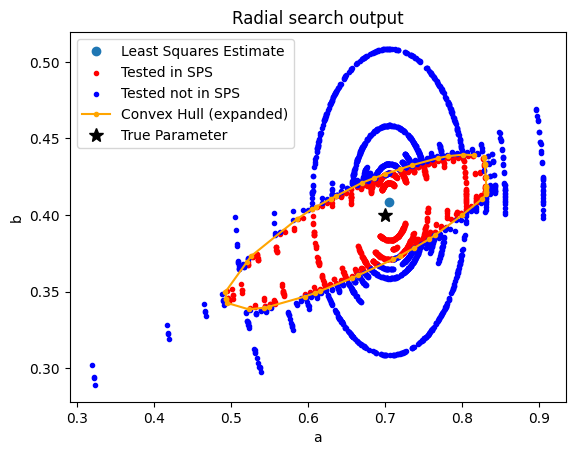

In [ ]:
# Test one model
def test_model(armax_model: ARMAX, n_vectors):
    n_a = len(armax_model.A) - 1
    n_b = len(armax_model.B)
    n_dim = n_a + n_b

    # Initialise the system
    R = signal.square(np.linspace(0, 10*np.pi, n_samples))
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.1)

    # Wraper function for calling SPS algorithm with model parameters
    def test_wrapper ( coords):
        global n_sps_calls
        n_sps_calls += 1    # Increment the call count

        return sps_test_function( tuple(coords), armax_model.F, armax_model.L, U, Y, n_a, n_b)

    # Calculate the LSE
    lse = get_lse(U, Y, armax_model, n_a, n_b )

    search = RadialSearch(n_dim=n_dim,
                            n_vectors=n_vectors,
                            center=lse,
                            sps_test_function=test_wrapper)


    return lse, *search.search()

n_random_vectors = 500

lse, ins, outs, boundaries, hull, expanded_hull = test_model(ol_1, n_vectors=n_random_vectors)
print("Average SPS calls per angle: %.2f" % ((len(ins) + len(outs)) / n_random_vectors))
print("Total SPS calls: %d" % (len(ins) + len(outs)))
plot_2d_results(lse, ins, outs, boundaries, hull, expanded_hull)

In [ ]:
# Simple Benchmark
import time

test_models = [ol_1, ol_2, cl_1, cl_2]
test_n_vectors = [10, 25, 50, 100, 250, 500, 1000]
num_iters = 50

curr_results = []
models_dict = {}

n_sps_calls = 0

for model_under_test in test_models:
    n_a = len(model_under_test.A) - 1
    n_b = len(model_under_test.B)
    n_dim = n_a + n_b

    # Initialise the system
    R = signal.square(np.linspace(0, 10*np.pi, n_samples))
    Y, U, N, R = model_under_test.simulate(n_samples, R, noise_std=0.1)
    lse = get_lse(U, Y, model_under_test, n_a, n_b )

    # Wraper function for calling SPS algorithm with model parameters
    def test_wrapper ( coords):
        global n_sps_calls
        n_sps_calls += 1    # Increment the call count

        return sps_test_function( tuple(coords), model_under_test.F, model_under_test.L, U, Y, n_a, n_b)

    results_dict = {}

    for n_vectors in test_n_vectors:

        search = RadialSearch(n_dim=n_dim,
                              n_vectors=n_vectors,
                              center=lse,
                              sps_test_function=test_wrapper)

        for _ in range(num_iters):
            n_sps_calls = 0
            print(model_under_test, ":", n_vectors, "-", _)
            start_time = time.time()
            ins, outs, boundaries, hull, expanded_hull = search.search()
            end_time = time.time()
            print("N SPS: ", n_sps_calls)

            curr_results.append(end_time - start_time)

        results_dict[n_vectors] = np.array(curr_results)
    models_dict[model_under_test] = results_dict




<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 0
N SPS:  51
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 1
N SPS:  38
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 2
N SPS:  37
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 3
N SPS:  39
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 4
N SPS:  38
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 5
N SPS:  39
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 6
N SPS:  37
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 7
N SPS:  40
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 8
N SPS:  37
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 9
N SPS:  40
<indirect_identification.armax.ARMAX object at 0x000002D5A5B000B0> : 10 - 10
N SPS:  37
<indirect_identification.armax.ARMAX objec

KeyboardInterrupt: 

In [ ]:
print(results_dict)


for model_under_test in test_models:
    for x in test_n_vectors:
        mean = np.mean(models_dict[model_under_test][x])
        print(mean)

1195
{10: array([0.01407075, 0.00850415, 0.0105052 , 0.00950933, 0.01050329,
       0.01050663, 0.01025105, 0.01003051, 0.01102161, 0.01003122,
       0.0095036 , 0.01050496, 0.00950384, 0.00950432, 0.00950933,
       0.0115056 , 0.01023412, 0.01050377, 0.01001906, 0.01000786,
       0.01051378, 0.01050758, 0.01103616, 0.01002049, 0.00950265,
       0.01050496, 0.00995207, 0.01022458, 0.01078296, 0.00981998,
       0.01050615, 0.00950861, 0.01121163, 0.0095036 , 0.01050878,
       0.01050329, 0.00920129, 0.01088881, 0.0112133 , 0.00992322,
       0.01000357, 0.01098824, 0.01120615, 0.00950193, 0.00950336,
       0.01125383, 0.00950432, 0.01006436, 0.01040125, 0.01119232,
       0.03351974, 0.02851367, 0.02881002, 0.02651954, 0.02500987,
       0.0255146 , 0.02692866, 0.02751899, 0.02821159, 0.02719522,
       0.02601027, 0.02903652, 0.02710938, 0.02802682, 0.02651739,
       0.02891207, 0.02851748, 0.02774453, 0.02838278, 0.02752256,
       0.0280149 , 0.0286448 , 0.02924275, 0.0288374

KeyError: <indirect_identification.armax.ARMAX object at 0x000002D5A60D8290>

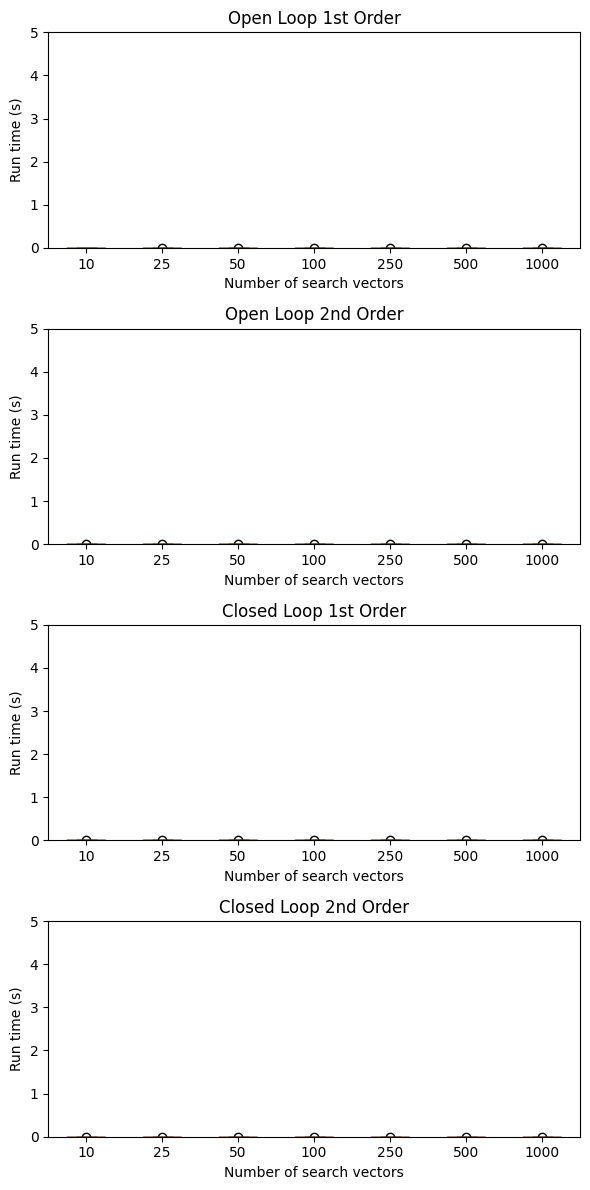

In [ ]:
# Plot results
# print(results_dict.keys())

# Create a figure with 4 rows and 1 column
plot_titles = ["Open Loop 1st Order", "Open Loop 2nd Order", "Closed Loop 1st Order", "Closed Loop 2nd Order"]
fig, axs = plt.subplots(4, 1, figsize=(6, 12))  # Adjust figsize as needed

# Plot something in each subplot
for i, ax in enumerate(axs):
    data = list(models_dict.values())[i]
    ax.boxplot(list(data.values()))
    ax.set_title(plot_titles[i])
    ax.set_xticklabels(test_n_vectors)
    ax.set_xlabel("Number of search vectors")
    ax.set_ylabel("Run time (s)")
    ax.set_ylim(np.array([0, 5]))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(np.array(list(results_dict.values())) * 1000)

In [ ]:
# benchmark
import cProfile, pstats
profiler = cProfile.Profile()

n_vectors_test = [10, 25, 50, 100, 250, 500, 1000]
num_iters = 100

results = []
results_dict = {}



try:
    for n_vectors in n_vectors_test:
        print("Testing", n_vectors)
        profiler.enable()
        params_ls, ins, outs, boundaries, hull, expanded_hull = test_model(ol_1, n_vectors = n_vectors)
        profiler.disable()
        stats = pstats.Stats(profiler).sort_stats('cumtime')
        stats.print_stats()
except Exception as e:
    print(e)
    profiler.disable()


Testing 10
name 'test_model' is not defined
